# ===============================================================================
* NOTEBOOK 5 : SAUVEGARDE MODÈLE ET SCÉNARIOS DE TEST
* Projet : Modèle de prévision de l'occupation des stades
# ===============================================================================

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage

In [86]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')

# 1. CHARGEMENT DES DONNÉES ET RÉENTRAÎNEMENT DU MEILLEUR MODÈLE

In [87]:
print("\n[1] RÉENTRAÎNEMENT DU MEILLEUR MODÈLE")
print("-"*80)

# Charger les données
df = pd.read_csv('../data/pca/data_with_pca.csv')
print(f"✓ Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Charger la comparaison des modèles pour identifier le meilleur
comparison = pd.read_csv('../data/prediction/models_comparison.csv')
best_model_name = comparison.loc[comparison['R² Test'].idxmax(), 'Modèle']
print(f"✓ Meilleur modèle identifié : {best_model_name}")

# Définir les features selon le meilleur modèle
if best_model_name == 'Variables Originales':
    features = [
        'Capacite', 'prix_billet_moyen', 'temperature', 'isDerby',
        'is_important_match', 'is_top_team_home', 'est_weekend',
        'mois', 'jour_semaine', 'derby_top_team'
    ]
elif best_model_name == 'Composantes Principales':
    features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
else:  # Hybride
    features = [
        'Capacite', 'prix_billet_moyen', 'temperature', 'isDerby',
        'is_important_match', 'is_top_team_home', 'est_weekend',
        'mois', 'jour_semaine', 'derby_top_team', 'PC1', 'PC2'
    ]

# Filtrer les features disponibles
features = [f for f in features if f in df.columns]
print(f"✓ Features utilisées : {len(features)}")
print(f"  {', '.join(features)}")

# Préparer les données (sur l'ensemble complet pour le déploiement)
target = 'affluence_moyenne'
df_model = df.dropna(subset=[target])
X = df_model[features]
y = df_model[target]

print(f"\n✓ Données préparées :")
print(f"  - Observations : {len(X)}")
print(f"  - Features : {len(features)}")

# Entraîner le modèle final sur toutes les données
# Création et entraînement du modèle
model_final = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights="distance")),
    ("model", LinearRegression())
])

# Entraînement
model_final.fit(X, y)

print(f"\n✓ Modèle entraîné sur l'ensemble des données")
print(f"  - R² sur données complètes : {model_final.score(X, y):.4f}")
print(f"  - Intercept : {model_final.named_steps['model'].intercept_:.2f}")



[1] RÉENTRAÎNEMENT DU MEILLEUR MODÈLE
--------------------------------------------------------------------------------
✓ Données chargées : 363 lignes, 41 colonnes
✓ Meilleur modèle identifié : Approche Hybride
✓ Features utilisées : 12
  Capacite, prix_billet_moyen, temperature, isDerby, is_important_match, is_top_team_home, est_weekend, mois, jour_semaine, derby_top_team, PC1, PC2

✓ Données préparées :
  - Observations : 363
  - Features : 12

✓ Modèle entraîné sur l'ensemble des données
  - R² sur données complètes : 0.7797
  - Intercept : 26530.63


# 2. SAUVEGARDE DU MODÈLE ET DES OBJETS NÉCESSAIRES

In [88]:
print("\n[2] SAUVEGARDE DES MODÈLES ET OBJETS")
print("-"*80)

import os
os.makedirs('../models', exist_ok=True)

# 1. Sauvegarder le modèle principal
with open('../models/model_affluence.pkl', 'wb') as f:
    pickle.dump(model_final, f)
print("✓ Modèle principal sauvegardé : models/model_affluence.pkl")

# 2. Sauvegarder la liste des features
with open('../models/features_list.pkl', 'wb') as f:
    pickle.dump(features, f)
print("✓ Liste des features sauvegardée : models/features_list.pkl")

# 3. Sauvegarder les statistiques pour normalisation (si nécessaire)
stats_dict = {
    'feature_names': features,
    'feature_means': X.mean().to_dict(),
    'feature_stds': X.std().to_dict(),
    'target_mean': y.mean(),
    'target_std': y.std()
}

with open('../models/model_stats.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)
print("✓ Statistiques sauvegardées : models/model_stats.pkl")

# 4. Sauvegarder les métadonnées du modèle
metadata = {
    'model_name': best_model_name,
    'features': features,
    'n_features': len(features),
    'n_observations': len(X),
    'r2_score': model_final.score(X, y),
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'intercept': model_final.named_steps['model'].intercept_,
    'coefficients': dict(zip(features, model_final.named_steps['model'].coef_))
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Métadonnées sauvegardées : models/model_metadata.pkl")


[2] SAUVEGARDE DES MODÈLES ET OBJETS
--------------------------------------------------------------------------------
✓ Modèle principal sauvegardé : models/model_affluence.pkl
✓ Liste des features sauvegardée : models/features_list.pkl
✓ Statistiques sauvegardées : models/model_stats.pkl
✓ Métadonnées sauvegardées : models/model_metadata.pkl


# 3. TEST DE CHARGEMENT DU MODÈLE

In [89]:
print("\n[3] TEST DE CHARGEMENT DU MODÈLE")
print("-"*80)

# Charger le modèle
with open('../models/model_affluence.pkl', 'rb') as f:
    model_loaded = pickle.load(f)

# Charger les features
with open('../models/features_list.pkl', 'rb') as f:
    features_loaded = pickle.load(f)

# Tester une prédiction
test_sample = X.iloc[0:1]
prediction_original = model_final.predict(test_sample)[0]
prediction_loaded = model_loaded.predict(test_sample)[0]

print(f"✓ Modèle chargé avec succès")
print(f"  - Prédiction modèle original : {prediction_original:.2f}")
print(f"  - Prédiction modèle chargé : {prediction_loaded:.2f}")
print(f"  - Différence : {abs(prediction_original - prediction_loaded):.6f} (doit être ~0)")



[3] TEST DE CHARGEMENT DU MODÈLE
--------------------------------------------------------------------------------
✓ Modèle chargé avec succès
  - Prédiction modèle original : 21487.38
  - Prédiction modèle chargé : 21487.38
  - Différence : 0.000000 (doit être ~0)


# 4. CRÉATION DES SCÉNARIOS DE TEST

In [90]:
print("\n[4] CRÉATION DES SCÉNARIOS DE TEST")
print("-"*80)

# Définir des scénarios réalistes basés sur les données
scenarios = []

# SCÉNARIO 1 : Match classique Botola Pro en semaine
scenario_1 = {
    'nom': 'Match classique Botola Pro - Semaine',
    'Competition': 'Botola Pro',
    'Capacite': 45000,
    'prix_billet_moyen': 50,
    'temperature': 22,
    'isDerby': 0,
    'is_important_match': 0,
    'is_top_team_home': 0,
    'est_weekend': 0,
    'mois': 3,
    'jour_semaine': 2,  # Mercredi
    'derby_top_team': 0
}
scenarios.append(scenario_1)

# SCÉNARIO 2 : Derby important - Weekend
scenario_2 = {
    'nom': 'Derby Botola Pro - Weekend',
    'Competition': 'Botola Pro',
    'Capacite': 67000,
    'prix_billet_moyen': 150,
    'temperature': 25,
    'isDerby': 1,
    'is_important_match': 1,
    'is_top_team_home': 1,
    'est_weekend': 1,
    'mois': 5,
    'jour_semaine': 6,  # Dimanche
    'derby_top_team': 1
}
scenarios.append(scenario_2)

# SCÉNARIO 3 : Match Champions League - Soirée
scenario_3 = {
    'nom': 'Ligue des Champions - Match important',
    'Competition': 'Champions League',
    'Capacite': 60000,
    'prix_billet_moyen': 200,
    'temperature': 18,
    'isDerby': 0,
    'is_important_match': 1,
    'is_top_team_home': 1,
    'est_weekend': 0,
    'mois': 4,
    'jour_semaine': 2,  # Mercredi
    'derby_top_team': 0
}
scenarios.append(scenario_3)

# SCÉNARIO 4 : Petit stade - Match modeste
scenario_4 = {
    'nom': 'Petit stade - Match normal',
    'Competition': 'Botola Pro',
    'Capacite': 15000,
    'prix_billet_moyen': 30,
    'temperature': 28,
    'isDerby': 0,
    'is_important_match': 0,
    'is_top_team_home': 0,
    'est_weekend': 1,
    'mois': 8,
    'jour_semaine': 5,  # Samedi
    'derby_top_team': 0
}
scenarios.append(scenario_4)

# SCÉNARIO 5 : Finale CAN 2025
scenario_5 = {
    'nom': 'Finale CAN 2025',
    'Competition': 'CAN',
    'Capacite': 68700,
    'prix_billet_moyen': 700,
    'temperature': 16,
    'isDerby': 1,
    'is_important_match': 1,
    'is_top_team_home': 1,
    'est_weekend': 1,
    'mois': 1,
    'jour_semaine': 6,  # Dimanche
    'derby_top_team': 1
}
scenarios.append(scenario_5)

# SCÉNARIO 6 : Match par temps froid
scenario_6 = {
    'nom': 'Match hiver - Froid',
    'Competition': 'Botola Pro',
    'Capacite': 45000,
    'prix_billet_moyen': 50,
    'temperature': 8,
    'isDerby': 0,
    'is_important_match': 0,
    'is_top_team_home': 1,
    'est_weekend': 1,
    'mois': 1,
    'jour_semaine': 6,  # Dimanche
    'derby_top_team': 0
}
scenarios.append(scenario_6)

# SCÉNARIO 7 : Grand stade - Top team vs Top team
scenario_7 = {
    'nom': 'Choc au sommet - Grand stade',
    'Competition': 'Botola Pro',
    'Capacite': 67000,
    'prix_billet_moyen': 120,
    'temperature': 23,
    'isDerby': 0,
    'is_important_match': 1,
    'is_top_team_home': 1,
    'est_weekend': 1,
    'mois': 4,
    'jour_semaine': 5,  # Samedi
    'derby_top_team': 0
}
scenarios.append(scenario_7)

# SCÉNARIO 8 : Match de clôture de saison
scenario_8 = {
    'nom': 'Dernier match de saison',
    'Competition': 'Botola Pro',
    'Capacite': 45000,
    'prix_billet_moyen': 60,
    'temperature': 30,
    'isDerby': 0,
    'is_important_match': 1,
    'is_top_team_home': 1,
    'est_weekend': 1,
    'mois': 6,
    'jour_semaine': 6,  # Dimanche
    'derby_top_team': 0
}
scenarios.append(scenario_8)

print(f"✓ {len(scenarios)} scénarios créés")


[4] CRÉATION DES SCÉNARIOS DE TEST
--------------------------------------------------------------------------------
✓ 8 scénarios créés


# 5. PRÉDICTIONS SUR LES SCÉNARIOS

In [91]:
print("\n[5] PRÉDICTIONS SUR LES SCÉNARIOS")
print("-"*80)

# Créer un DataFrame avec les scénarios
scenarios_df = pd.DataFrame(scenarios)

# Ajouter les composantes principales si nécessaire
if any('PC' in f for f in features):
    print("\n⚠ Le modèle utilise des composantes principales")
    print("  Pour un usage en production, il faudrait recalculer les PC à partir des variables originales")
    print("  Pour cette démonstration, on utilise des valeurs moyennes pour les PC manquantes")
    
    for pc in [f for f in features if f.startswith('PC')]:
        if pc not in scenarios_df.columns:
            scenarios_df[pc] = df[pc].mean()

# Extraire les features dans le bon ordre
X_scenarios = scenarios_df[features]

# Faire les prédictions
predictions = model_loaded.predict(X_scenarios)
scenarios_df['affluence_predite'] = predictions
scenarios_df['taux_occupation_predit'] = (scenarios_df['affluence_predite'] / scenarios_df['Capacite'] * 100).clip(0, 100)

# Afficher les résultats
print("\n5.1 Résultats des prédictions :")
print("="*100)

results_display = scenarios_df[['nom', 'Capacite', 'affluence_predite', 'taux_occupation_predit']].copy()
results_display['affluence_predite'] = results_display['affluence_predite'].round(0).astype(int)
results_display['taux_occupation_predit'] = results_display['taux_occupation_predit'].round(1)

for idx, row in results_display.iterrows():
    print(f"\n{idx+1}. {row['nom']}")
    print(f"   Capacité du stade : {row['Capacite']:,} places")
    print(f"   Affluence prédite : {row['affluence_predite']:,} spectateurs")
    print(f"   Taux d'occupation : {row['taux_occupation_predit']:.1f}%")
    print("-"*100)



[5] PRÉDICTIONS SUR LES SCÉNARIOS
--------------------------------------------------------------------------------

⚠ Le modèle utilise des composantes principales
  Pour un usage en production, il faudrait recalculer les PC à partir des variables originales
  Pour cette démonstration, on utilise des valeurs moyennes pour les PC manquantes

5.1 Résultats des prédictions :

1. Match classique Botola Pro - Semaine
   Capacité du stade : 45,000 places
   Affluence prédite : 34,279 spectateurs
   Taux d'occupation : 76.2%
----------------------------------------------------------------------------------------------------

2. Derby Botola Pro - Weekend
   Capacité du stade : 67,000 places
   Affluence prédite : -49,959 spectateurs
   Taux d'occupation : 0.0%
----------------------------------------------------------------------------------------------------

3. Ligue des Champions - Match important
   Capacité du stade : 60,000 places
   Affluence prédite : 7,932 spectateurs
   Taux d'occu

# 6. VISUALISATION DES SCÉNARIOS


[6] VISUALISATION DES SCÉNARIOS
--------------------------------------------------------------------------------
✓ Visualisations sauvegardées : ../visualisation/models/scenarios_predictions.png


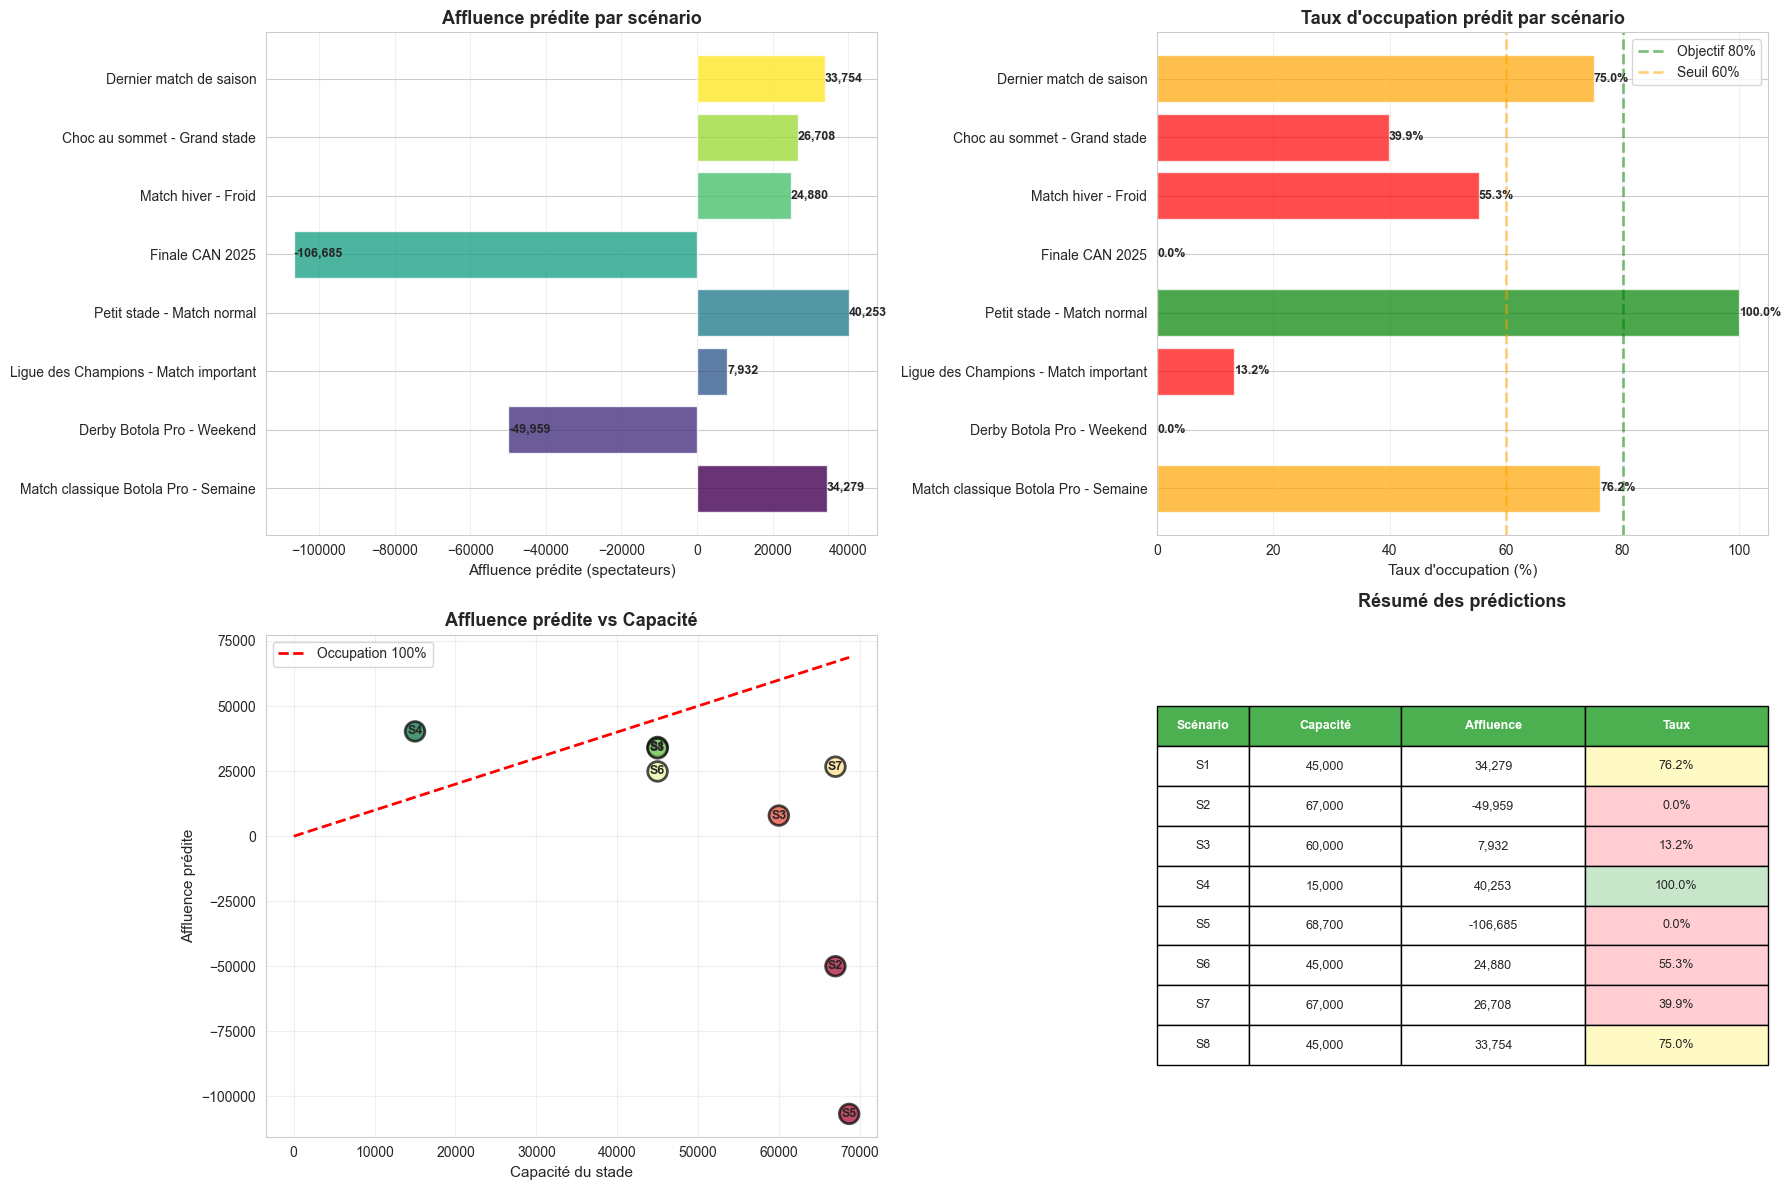

In [92]:
print("\n[6] VISUALISATION DES SCÉNARIOS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Affluence prédite par scénario
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios_df)))
bars = ax1.barh(scenarios_df['nom'], scenarios_df['affluence_predite'], color=colors, alpha=0.8)
ax1.set_xlabel('Affluence prédite (spectateurs)', fontsize=11)
ax1.set_title('Affluence prédite par scénario', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars, scenarios_df['affluence_predite'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2, f'{val:,.0f}', 
             va='center', ha='left', fontsize=9, fontweight='bold')

# 2. Taux d'occupation par scénario
ax2 = axes[0, 1]
colors_taux = ['green' if x >= 80 else 'orange' if x >= 60 else 'red' 
               for x in scenarios_df['taux_occupation_predit']]
bars2 = ax2.barh(scenarios_df['nom'], scenarios_df['taux_occupation_predit'], 
                 color=colors_taux, alpha=0.7)
ax2.set_xlabel('Taux d\'occupation (%)', fontsize=11)
ax2.set_title('Taux d\'occupation prédit par scénario', fontsize=13, fontweight='bold')
ax2.axvline(x=80, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Objectif 80%')
ax2.axvline(x=60, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Seuil 60%')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for bar, val in zip(bars2, scenarios_df['taux_occupation_predit']):
    ax2.text(val, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', ha='left', fontsize=9, fontweight='bold')

# 3. Affluence vs Capacité
ax3 = axes[1, 0]
ax3.scatter(scenarios_df['Capacite'], scenarios_df['affluence_predite'], 
            s=200, c=scenarios_df['taux_occupation_predit'], cmap='RdYlGn', 
            alpha=0.7, edgecolors='black', linewidth=2)
ax3.plot([0, scenarios_df['Capacite'].max()], [0, scenarios_df['Capacite'].max()], 
         'r--', linewidth=2, label='Occupation 100%')
ax3.set_xlabel('Capacité du stade', fontsize=11)
ax3.set_ylabel('Affluence prédite', fontsize=11)
ax3.set_title('Affluence prédite vs Capacité', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Ajouter les noms des scénarios
for idx, row in scenarios_df.iterrows():
    ax3.annotate(f"S{idx+1}", (row['Capacite'], row['affluence_predite']),
                fontsize=9, fontweight='bold', ha='center', va='center')

# 4. Tableau récapitulatif
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

table_data = []
for idx, row in scenarios_df.iterrows():
    table_data.append([
        f"S{idx+1}",
        f"{row['Capacite']:,}",
        f"{row['affluence_predite']:,.0f}",
        f"{row['taux_occupation_predit']:.1f}%"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Scénario', 'Capacité', 'Affluence', 'Taux'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15, 0.25, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style du tableau
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 3:  # Colonne taux
                taux = float(table_data[i-1][3].strip('%'))
                if taux >= 80:
                    cell.set_facecolor('#c8e6c9')
                elif taux >= 60:
                    cell.set_facecolor('#fff9c4')
                else:
                    cell.set_facecolor('#ffcdd2')

ax4.set_title('Résumé des prédictions', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
output_path = "../visualisation/models"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/scenarios_predictions.png", dpi=300, bbox_inches='tight')
print(f"✓ Visualisations sauvegardées : {output_path}/scenarios_predictions.png")
plt.show()

# 7. EXPORT DES SCÉNARIOS

In [93]:
print("\n[7] EXPORT DES SCÉNARIOS")
print("-"*80)

# Sauvegarder les scénarios avec prédictions
scenarios_export = scenarios_df[[
    'nom', 'Competition', 'Capacite', 'prix_billet_moyen', 'temperature',
    'isDerby', 'is_important_match', 'is_top_team_home', 'est_weekend',
    'affluence_predite', 'taux_occupation_predit'
]].copy()

scenarios_export.to_csv('../data/models/scenarios_test.csv', index=False, encoding='utf-8')
print("✓ Scénarios exportés : data/models/scenarios_test.csv")



[7] EXPORT DES SCÉNARIOS
--------------------------------------------------------------------------------
✓ Scénarios exportés : data/models/scenarios_test.csv


# 8. FONCTION DE PRÉDICTION RÉUTILISABLE

In [94]:
print("\n[8] CRÉATION D'UNE FONCTION DE PRÉDICTION")
print("-"*80)

# Créer un script Python avec une fonction de prédiction
prediction_script = """
# Script de prédiction - Occupation des stades
# Généré automatiquement

import pickle
import pandas as pd
import numpy as np

def charger_modele():
    \"\"\"Charge le modèle et les métadonnées\"\"\"
    with open('../models/model_affluence.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('../models/features_list.pkl', 'rb') as f:
        features = pickle.load(f)
    
    with open('../models/model_metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    return model, features, metadata

def predire_affluence(capacite, prix_billet, temperature, is_derby, 
                      is_important, is_top_team, is_weekend, mois, 
                      jour_semaine, derby_top_team=None):
    \"\"\"
    Prédit l'affluence pour un match donné
    
    Paramètres:
    -----------
    capacite : int
        Capacité du stade
    prix_billet : float
        Prix moyen du billet
    temperature : float
        Température en degrés Celsius
    is_derby : int (0 ou 1)
        1 si c'est un derby, 0 sinon
    is_important : int (0 ou 1)
        1 si match important, 0 sinon
    is_top_team : int (0 ou 1)
        1 si équipe majeure à domicile, 0 sinon
    is_weekend : int (0 ou 1)
        1 si weekend, 0 sinon
    mois : int (1-12)
        Mois du match
    jour_semaine : int (0-6)
        0=Lundi, 6=Dimanche
    derby_top_team : int (0 ou 1), optionnel
        Interaction derby x top team
    
    Retourne:
    ---------
    dict : Dictionnaire avec affluence_predite et taux_occupation
    \"\"\"
    
    # Charger le modèle
    model, features, metadata = charger_modele()
    
    # Calculer derby_top_team si non fourni
    if derby_top_team is None:
        derby_top_team = int(is_derby and is_top_team)
    
    # Créer le DataFrame d'entrée
    input_data = pd.DataFrame([{
        'Capacite': capacite,
        'prix_billet_moyen': prix_billet,
        'temperature': temperature,
        'isDerby': is_derby,
        'is_important_match': is_important,
        'is_top_team_home': is_top_team,
        'est_weekend': is_weekend,
        'mois': mois,
        'jour_semaine': jour_semaine,
        'derby_top_team': derby_top_team
    }])
    
    # Sélectionner uniquement les features nécessaires
    X = input_data[features]
    
    # Faire la prédiction
    affluence_predite = model.predict(X)[0]
    taux_occupation = min(100, max(0, (affluence_predite / capacite) * 100))
    
    return {
        'affluence_predite': round(affluence_predite, 0),
        'taux_occupation': round(taux_occupation, 1),
        'capacite': capacite
    }

# Exemple d'utilisation
if __name__ == "__main__":
    # Exemple : Derby important un dimanche
    resultat = predire_affluence(
        capacite=67000,
        prix_billet=150,
        temperature=25,
        is_derby=1,
        is_important=1,
        is_top_team=1,
        is_weekend=1,
        mois=5,
        jour_semaine=6
    )
    
    print("Prédiction:")
    print(f"  Affluence : {resultat['affluence_predite']:,.0f} spectateurs")
    print(f"  Taux d'occupation : {resultat['taux_occupation']:.1f}%")
"""

with open('../scripts/Prediction.py', 'w', encoding='utf-8') as f:
    f.write(prediction_script)

print("✓ Script de prédiction créé : scripts/Prediction.py")


[8] CRÉATION D'UNE FONCTION DE PRÉDICTION
--------------------------------------------------------------------------------
✓ Script de prédiction créé : scripts/Prediction.py


# 9. RAPPORT FINAL

In [95]:
print("\n[9] GÉNÉRATION DU RAPPORT FINAL")
print("-"*80)

rapport = f"""
RAPPORT DE DÉPLOIEMENT DU MODÈLE
=================================

1. MODÈLE SAUVEGARDÉ
   - Type : {best_model_name}
   - Nombre de features : {len(features)}
   - R² sur données complètes : {model_final.score(X, y):.4f}
   - Date de création : {metadata['creation_date']}

2. FICHIERS GÉNÉRÉS
   - models/model_affluence.pkl : Modèle principal
   - models/features_list.pkl : Liste des features
   - models/model_stats.pkl : Statistiques de normalisation
   - models/model_metadata.pkl : Métadonnées du modèle
   - scripts/Prediction.py : Script de prédiction réutilisable
   - data/models/scenarios_test.csv : Scénarios de test avec prédictions
   - virtualisation/models/scenarios_predictions.png : Visualisations

3. FEATURES UTILISÉES
   {chr(10).join([f"   - {f}" for f in features])}

4. SCÉNARIOS DE TEST ({len(scenarios)} scénarios)

{chr(10).join([f'''   Scénario {i+1}: {row['nom']}
   - Capacité : {row['Capacite']:,} places
   - Affluence prédite : {row['affluence_predite']:,.0f} spectateurs
   - Taux occupation : {row['taux_occupation_predit']:.1f}%
   ''' for i, row in scenarios_df.iterrows()])}

5. UTILISATION DU MODÈLE

   Option 1 : Utiliser le script Python
   -------------------------------------
   python scripts/Prediction.py
   
   Ou dans votre code Python :
   
   from scripts.Prediction import predire_affluence
   
   resultat = predire_affluence(
       capacite=68700,
       prix_billet=300,
       temperature=17,
       is_derby=1,
       is_important=1,
       is_top_team=1,
       is_weekend=0,
       mois=01,
       jour_semaine=3
   )
   
   print(f"Affluence : {{resultat['affluence_predite']}}")
   print(f"Taux : {{resultat['taux_occupation']}}%")

   Option 2 : Charger directement le modèle
   -----------------------------------------
   import pickle
   
   with open('../models/model_affluence.pkl', 'rb') as f:
       model = pickle.load(f)
   
   # Préparer vos données au bon format
   # Faire la prédiction
   prediction = model.predict(X)

6. RECOMMANDATIONS
   
   - Réentraîner le modèle périodiquement avec de nouvelles données
   - Valider les prédictions sur des matchs réels
   - Monitorer les performances en production
   - Ajuster les features si nécessaire

7. LIMITATIONS
   
   - Le modèle suppose une relation linéaire entre variables
   - Précision réduite pour les cas extrêmes (très petits/grands stades)
   - Ne prend pas en compte les événements exceptionnels imprévus

Date de génération : {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('../rapport/rapport_deploiement.txt', 'w', encoding='utf-8') as f:
    f.write(rapport)

print("✓ Rapport de déploiement créé : ../rapport/rapport_deploiement.txt")

print("\n" + "="*80)
print("SAUVEGARDE ET SCÉNARIOS TERMINÉS AVEC SUCCÈS !")
print("="*80)

print(f"\nFICHIERS GÉNÉRÉS DANS LE DOSSIER 'models/' :")
print(f"  1. model_affluence.pkl - Modèle principal")
print(f"  2. features_list.pkl - Liste des features")
print(f"  3. model_stats.pkl - Statistiques")
print(f"  4. model_metadata.pkl - Métadonnées")
print(f"  5. predict.py - Script de prédiction Python")
print(f"  6. scenarios_test.csv - Scénarios avec résultats")
print(f"  7. scenarios_predictions.png - Visualisations")
print(f"  8. rapport_deploiement.txt - Documentation")

print("\n🎯 UTILISATION RAPIDE :")
print("="*80)
print("\nDans un nouveau script Python :")
print("""
import sys
sys.path.append('.')
from scripts.Prediction import predire_affluence

# Prédire pour un derby
resultat = predire_affluence(
    capacite=67000,
    prix_billet=150,
    temperature=25,
    is_derby=1,
    is_important=1,
    is_top_team=1,
    is_weekend=1,
    mois=5,
    jour_semaine=6
)

print(f"Affluence prédite : {resultat['affluence_predite']:,.0f}")
print(f"Taux d'occupation : {resultat['taux_occupation']:.1f}%")
""")

print("\n" + "="*80)
print("PROJET COMPLET TERMINÉ ! 🎉")
print("="*80)
print("\nVous avez maintenant :")
print("  ✅ 5 Notebooks complets (Nettoyage, EDA, ACP, Régression, Déploiement)")
print("  ✅ Modèle sauvegardé en .pkl")
print("  ✅ 8 scénarios de test réalistes")
print("  ✅ Script Python réutilisable pour prédictions")
print("  ✅ Visualisations et rapports détaillés")
print("\nBon courage pour votre présentation ! 🚀")


[9] GÉNÉRATION DU RAPPORT FINAL
--------------------------------------------------------------------------------
✓ Rapport de déploiement créé : ../rapport/rapport_deploiement.txt

SAUVEGARDE ET SCÉNARIOS TERMINÉS AVEC SUCCÈS !

FICHIERS GÉNÉRÉS DANS LE DOSSIER 'models/' :
  1. model_affluence.pkl - Modèle principal
  2. features_list.pkl - Liste des features
  3. model_stats.pkl - Statistiques
  4. model_metadata.pkl - Métadonnées
  5. predict.py - Script de prédiction Python
  6. scenarios_test.csv - Scénarios avec résultats
  7. scenarios_predictions.png - Visualisations
  8. rapport_deploiement.txt - Documentation

🎯 UTILISATION RAPIDE :

Dans un nouveau script Python :

import sys
sys.path.append('.')
from scripts.Prediction import predire_affluence

# Prédire pour un derby
resultat = predire_affluence(
    capacite=67000,
    prix_billet=150,
    temperature=25,
    is_derby=1,
    is_important=1,
    is_top_team=1,
    is_weekend=1,
    mois=5,
    jour_semaine=6
)

print(f"Aff